# Prerequisites

- AE pdf
- Fields

# Theory

- https://www.youtube.com/watch?v=g_eY7JXOc8U - Must watch

## Algorithm

**High level overview**
- AES CTR mode for encryption
- GHASH function for authentication 

Let 
- $(E, D)$ be the block cipher over $(\mathcal{K}, \mathcal{X})$ where $\mathcal{X}= \{0,1\}^{128}$
- $GHASH$ a keyed hash function 


**Algorithm**

Input: key $k$, message $m$, associated data $d$ and nonce $n∈\{0,1\}^{96}$ (if $len(n) < 96$ there is a special algorithm performed)

Generate key for GHASH
- $H = E(k, 0^{128})$ = key for $GHASH$

Initiate counter
- $ctr = (n || 0^{31} || 1) \in \{0,1\}^{128}$ = counter
- $ctr' = ctr+1$ = counter starts from $ctr+1$


Encryption
- $c = m \oplus E(k, ctr')$
- $c_{pad} =  c || 0^{128-len(c)} \in \{0,1\}^{128}$
- $d_{pad} =  d || 0^{128-len(d)} \in \{0,1\}^{128}$

MAC
- $h = GHASH(H, \ (d'|| c' || len(d) || len(c)\ ) \in \{0,1\}^{128}$
- $t = h \oplus E(k, ctr) \in \{0,1\}^{128}$

Return $(c, t)$

For 
- $IV = n$
- $j0 = ctr$
- $P = m$
- $A = d$
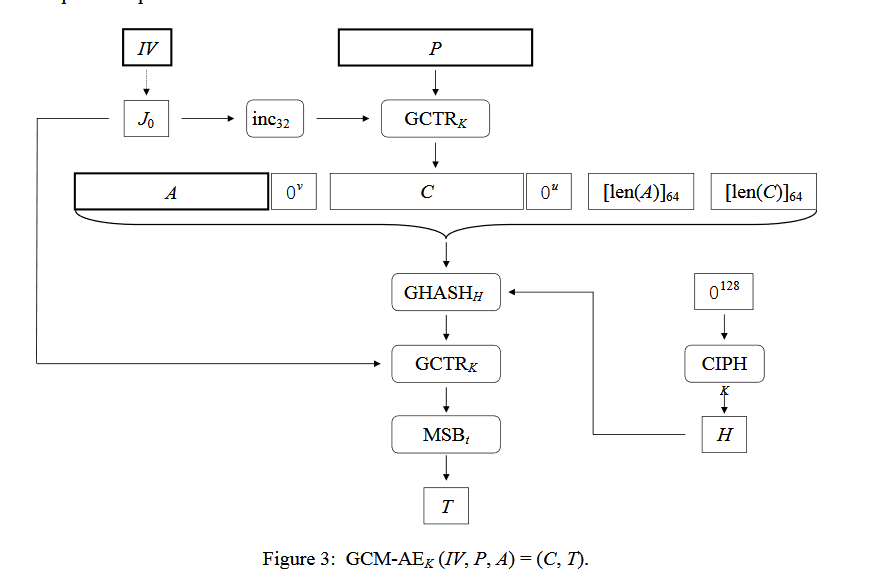

## GHASH

GHASH works in the field $GF(2^{128}) \bmod X^{128} + X^7 + X^2 + X + 1$
- The field has coefficients in $\{0,1\}$
- Strings of 128 bits can be converted into polynomials -> the bits are the coefficients

For 
- a key $k∈GF(2^{128})$ 
- an input vector $z = (z_0, z_1, ... z_{v-1}) ∈(GF(2^{128}))^v$

$$GHASH(k, z) = z_0k^v + z_1k^{v-1} + z_{v-1}k \in GF(2^{128})$$

for our case $z = d'|| c' || len(d) || len(c)$

# Code

https://nvlpubs.nist.gov/nistpubs/Legacy/SP/nistspecialpublication800-38d.pdf

In [1]:
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from Crypto.Util.number import long_to_bytes, bytes_to_long
from Crypto.Util import Counter

In [2]:
#Utils
# https://toadstyle.org/cryptopals/63.txt
def poly_mul(a, b):
    p = 0
    while a > 0:
        if a & 1:
            p = p ^ b
        a = a >> 1
        b = b << 1

    return p

def deg(a):
    d = 0
    while (a!=0):
        a = a >> 1
        d+=1
    return d
    
def poly_divmod(a, b):
    q, r = 0, a

    while deg(r) >= deg(b):
        d = deg(r) - deg(b)
        q = q ^ (1 << d)
        r = r ^ (b << d)

    return q, r


def poly_modmul(a, b, m):
    p = 0
    while a > 0:
        if a & 1:
            p = p ^ b
        a = a >> 1
        b = b << 1
        if deg(b) == deg(m):
            b = b ^ m

    return p

#https://github.com/bozhu/AES-GCM-Python/blob/master/aes_gcm.py stolen from here
def gf_2_128_mul(x, y):
    assert x < (1 << 128)
    assert y < (1 << 128)
    res = 0
    for i in range(127, -1, -1):
        res ^= x * ((y >> i) & 1)  # branchless
        x = (x >> 1) ^ ((x & 1) * 0xE1000000000000000000000000000000)
    assert res < 1 << 128
    return res


In [3]:
def split_bytes(l, block_size):
    return [l[i:i+block_size] for i in range(0, len(l), block_size)]
def xor_bytes(a, b):
    return bytes([aa^bb for (aa, bb) in zip(a,b)])

In [6]:
mod = (1<< 128) | (1<< 7) | (1<< 2) | (1<< 1) | 1
bin(poly_modmul((1 << 129), 1, mod))

'0b100001110'

In [145]:
class AESGCM():
    def __init__(self):
        self.mod = (1<< 128) | (1<< 7) | (1<< 2) | (1<< 1) | 1
    
    
    def encrypt(self, k, m, d, n):
        '''
        Input: k = aes key; m = message; d = associated data; n = nonce
        Output: c = ciphertext; t = tag
        '''
        #get ghash key
        H = AES.new(k, AES.MODE_ECB).encrypt(b'\x00' * 16) #bytes
        H = bytes_to_long(H) #int
        H = poly_modmul(H, 1, self.mod) #get it into the field
        

        ctr = self.check_iv(H, n)
        ctr_= long_to_bytes((bytes_to_long(ctr) + 1) & 0xffffffff) #ctr_ = ctr + 1
        #init ctr cipher
        cipher = AES.new(k, AES.MODE_CTR, initial_value =ctr_, nonce = ctr[:12])
        
        # Encryption
        # nonce_enc = cipher.encrypt(b'\x00' * 16) #encrypting CTR with plaintext 0 is the same as encrypting the first IV
        nonce_enc = AES.new(k, AES.MODE_ECB).encrypt(ctr)
        if len(m) == 0:
            c = cipher.encrypt(b'\x00' * 16) #encrypting CTR with plaintext 0 is the same as encrypting the first IV
        else:
            c = cipher.encrypt(m) #we do this for the 0 case
            
        # Tag
        # construct ghash input
        c_ = c + b'\x00' * (-len(c) % 16) # end pad with 0
        d_ = d + b'\x00' * (-len(d) % 16) # end pad with 0
        
        len_c = long_to_bytes(len(c) * 8)
        len_c_ = b'\x00' * (-len(len_c) % 8)  + len_c # front pad with 0
        len_d = long_to_bytes(len(d) * 8)
        len_d_ = b'\x00' * (-len(len_d) % 8)  + len_d # frontpad with 0
        lens = len_d_ + len_c_
        
        z = d_ + c_ + lens
        assert(len(z) % 16 == 0), 'z len error'
        zs = split_bytes(z, 16) #split into 128b blocks
        
        # ghash
        h = self.ghash(H, zs)
        t = xor_bytes(h, nonce_enc)
        
        return c, t
        
    def check_iv(self, H, n):
        #check iv
        assert (len(n) > 0), 'iv cannot be null'
        assert(len(n) <= 12), 'iv too long'
        if len(n) < 12:
            fill = (16 - (len(n) % 16)) % 16 + 8
            ghash_in = split_bytes(n + b'\x00' * fill + long_to_bytes(8 * len(n), 8), 16)
            j0 = self.ghash(H, ghash_in)
            n = j0[:12]
        else:
            j0 = n + b'\x00\x00\x00\x01'
        return j0
        
    def ghash(self, k, z):
        p = 0
        for zi in z:
            zi = poly_modmul(bytes_to_long(zi), 1, self.mod) #transform block in elem in GF
            #zi = bytes_to_long(zi)
            p = p ^ zi
            #p = poly_modmul(p, k, self.mod)
            p = gf_2_128_mul(p, k)
        return long_to_bytes(p)
        
    

## Library

In [146]:
msg = b'super_secret_msg'
data = b'dataaa'
key = get_random_bytes(16)
nonce = b'12Byte_No'

In [147]:
cipher = AES.new(key=key, mode=AES.MODE_GCM, nonce=nonce)
cipher.update(data)
c1, t1 = cipher.encrypt_and_digest(msg)
c1, t1

(b'\x01\t\x84\x8eb\xfc2+n\x1c\xb8I\xdcO4\r',
 b'<\x10T\x84\xd6\x03)\xe6\x19$.\x15\xbe\x14\xbap')

In [148]:
aesgcm = AESGCM()
c2, t2 =aesgcm.encrypt(key, msg, data, nonce)
c2 ,t2

(b'\x01\t\x84\x8eb\xfc2+n\x1c\xb8I\xdcO4\r',
 b'<\x10T\x84\xd6\x03)\xe6\x19$.\x15\xbe\x14\xbap')

# Resources

- https://en.wikipedia.org/wiki/Galois/Counter_Mode
- https://www.youtube.com/watch?v=R2SodepLWLg
- https://toadstyle.org/cryptopals/63.txt
- https://nvlpubs.nist.gov/nistpubs/Legacy/SP/nistspecialpublication800-38d.pdf - nist spec